In [1]:
import sys
sys.path.append("../../gaia_tools/")
sys.path.append("../../scripts/")
import covariance_generation as cov
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [64]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method,
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou}

other_curves_dict = {
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou,
                    'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method}

In [80]:
# Rotation Curve Plotting Function

def plot_rotation_curve(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False,
                        ):


    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    mcmc_fmts = ['o', 'd']
    for i_path, path in enumerate(mcmc_runs):
        bin_setup = load_bin_settings(mcmc_runs[i_path], is_print=False)
        bin_centers_r = bin_setup['bin_centers_r']

        if(i_path > 0):
            bin_centers_r = bin_centers_r/8.277*8.178

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-100, 100, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)
        
        bin_edges_r = bin_setup['bin_edges'][0][0]
        if(display_bin_edges):
            if(is_last_merged):
                # Remove middle boundary
                bin_edges_r = np.delete(bin_edges_r, -2)

            if(i_path > 0): continue
            ax.vlines(bin_edges_r, 150, 255, linestyles='dashed', alpha=0.5, colors=colors[i_path])   
            #x_ticks = np.round(bin_edges_r)
            #ax.set_xticks(x_ticks)

    plt.xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)


    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.xaxis.set_major_locator(MultipleLocator(2*1e3))
    ax.yaxis.set_major_locator(MultipleLocator(10))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


    lit_fmts = ['+', 'x', '^', 'v', '.', '0']
    lit_fmts = ['^', 'v', '.', '+', 'x', 'o']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey', 'red']
    lit_colors = ['brown', 'orange', 'grey', 'blue', 'green', 'red']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 26]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if((key == 'Eilers et al. 2018') or (key == 'Ou et al. 2023')):
                print(key)
                print(rc_data.columns)
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    plt.legend(prop={'size': 9}, ncol=2, columnspacing=3)

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    plt.xlim(4000, 25500)
    plt.rcParams["axes.grid"] = False




def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

In [32]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run'
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-06-05-17-01-35_full_run_parallax_cut_20_GSPPhot'
paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)

# Load run settings and print
bin_setup = load_bin_settings(path2, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run/sampler_2024-01-05-14-11-54.h5
/home/sven/repos/gaia-tools/out/mcmc_runs/2023-06-05-17-01-35_full_run_parallax_cut_20_GSPPhot/sampler_2023-06-05-17-01-35.h5
1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 13000.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        14000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        14000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.]]))
4. nbins= 8
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (665660, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 14542206.408749837), (6500.0, 16051176.139629288), (7500.0, 16753211.135520421), (8500.0, 17088750.790579934), (95

In [41]:
5500/8.277*8.178/1e3

5.434215295396885

In [33]:
bin_centers_r

array([ 5500.,  6500.,  7500.,  8500.,  9500., 10500., 11500., 13000.])

Sampler shape: (6000, 48, 13)


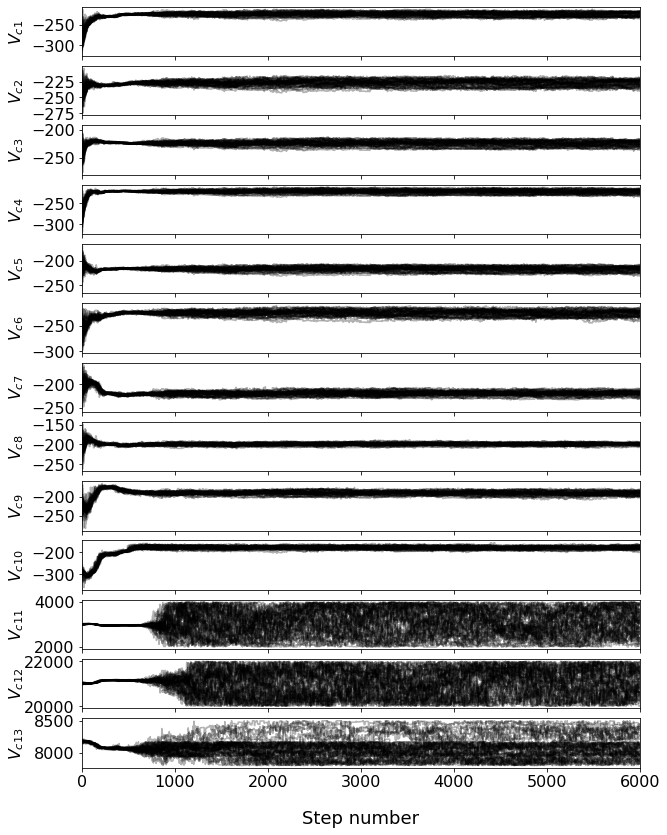

In [7]:
plot_walkers(samplers[0], 0)

R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
(10,)
(10,)
R, v_c, sig-, sig+
5.43 221.3 6.5 5.7
6.42 231.0 6.9 6.0
7.41 234.6 7.1 6.1
8.4 232.7 7.1 6.1
9.39 229.8 7.1 6.1
10.37 231.2 7.0 6.2
11.36 230.6 6.3 6.1
12.84 227.5 6.5 5.8
(8,)
(8,)
Wang et al. 2022
[ 9500. 10500. 11500. 12500. 13500. 14500. 15500. 16500. 17500. 18500.
 19500. 20500. 21500. 22500. 23500. 24500. 25500.]
Eilers et al. 2018
[ 5270.  5740.  6230.  6730.  7220.  7820.  8190.  8780.  9270.  9760.
 10260. 10750. 11250. 11750. 12250. 12740. 13230. 13740. 14240. 14740.
 15220. 15740. 16240. 16740. 17250. 17750. 18240. 18740. 19220. 19710.
 20270. 20780. 21240. 21800. 22140. 22730. 23660. 24820.]
Zhou et al. 2022
[ 5240.  5740.  6250.  6770.  7230.  7830.  8210.  8780.  9260.  9750.
 10250. 10750. 11250. 11750. 12240. 12740. 13250. 13740. 14230. 14740.


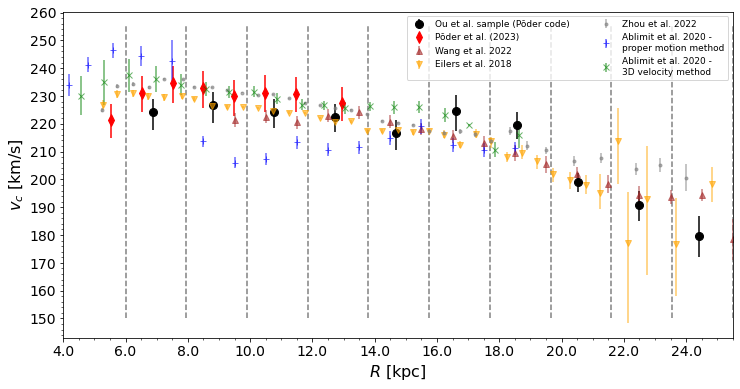

In [58]:
# Ou et al. sample (Poder code ) VS Poder et al. (2023)

extra_dims = [3, 3]
result_name_1 = 'Ou et al. sample (Põder code)'
result_name_2 = 'Põder et al. (2023)'

plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [2000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=True, 
                    display_bin_edges=True)

#plt.ylim(200, 270)
#plt.savefig("Ou_sample_RC.pdf", format='pdf', dpi=300, bbox_inches='tight')

## Figure 2: Ou et al. vs Ou et al. sample (Poder code)

In [67]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method,
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou}

other_curves_dict = {
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou,
                    'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method,
                    'Ou et al. 2023': ou_rc}

R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
(10,)
(10,)
Wang et al. 2022
[ 9500. 10500. 11500. 12500. 13500. 14500. 15500. 16500. 17500. 18500.
 19500. 20500. 21500. 22500. 23500. 24500. 25500.]
Eilers et al. 2018
[ 5270.  5740.  6230.  6730.  7220.  7820.  8190.  8780.  9270.  9760.
 10260. 10750. 11250. 11750. 12250. 12740. 13230. 13740. 14240. 14740.
 15220. 15740. 16240. 16740. 17250. 17750. 18240. 18740. 19220. 19710.
 20270. 20780. 21240. 21800. 22140. 22730. 23660. 24820.]
Eilers et al. 2018
Index(['R', 'v_c', 'sig_below', 'sig_above'], dtype='object')
Zhou et al. 2022
[ 5240.  5740.  6250.  6770.  7230.  7830.  8210.  8780.  9260.  9750.
 10250. 10750. 11250. 11750. 12240. 12740. 13250. 13740. 14230. 14740.
 15230. 15740. 16240. 16740. 17230. 17740. 18350. 18900. 19500. 20410.
 21280. 22390. 23160. 24000.]
A

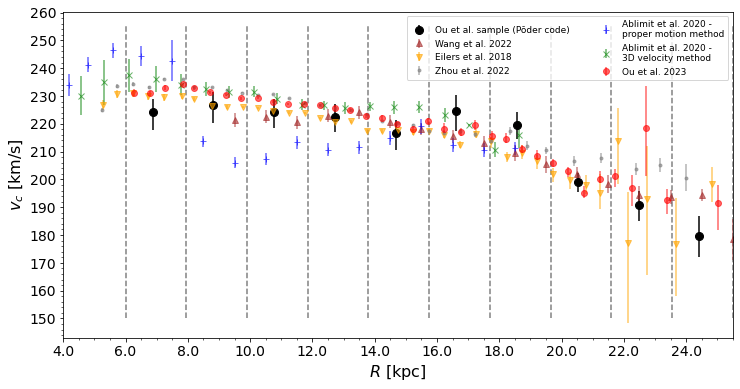

In [81]:
# Ou et al. VS Ou et al. sample (Poder code )

extra_dims = [3]
result_name_1 = 'Ou et al. sample (Põder code)'


plot_rotation_curve([paths[0]], 
                    [result_name_1],
                    [2000],
                    extra_dims=extra_dims,
                    display_eilers=True, 
                    display_bin_edges=True)

In [69]:
ou_rc

,R,v_c,sig_above,sig_below,N
0,6.27,231.07,1.28,1.00,764
1,6.78,230.93,0.97,0.97,676
2,7.28,232.87,1.13,0.79,812
3,7.86,234.14,0.63,0.62,1631
4,8.19,232.83,0.56,0.55,2270
5,8.71,231.27,0.54,0.66,1445
6,9.23,230.47,0.44,0.46,2179
7,9.72,229.16,0.54,0.43,2505
8,10.24,229.37,0.25,0.50,2560
9,10.74,227.95,0.53,0.34,2528


Ou data to CSV

In [59]:
import pandas as pd

# Provided data
data = {
    "R": [6.27, 6.78, 7.28, 7.86, 8.19, 8.71, 9.23, 9.72, 10.24, 10.74, 11.23, 11.73, 12.23, 12.73, 13.22, 13.72, 14.22,
          14.73, 15.24, 15.72, 16.24, 16.77, 17.21, 17.77, 18.23, 18.73, 19.22, 19.71, 20.22, 20.72, 21.22, 21.72, 22.27,
          22.71, 23.40, 25.02, 27.31],
    "v_c": [231.07, 230.93, 232.87, 234.14, 232.83, 231.27, 230.47, 229.16, 229.37, 227.95, 227.09, 227.15, 226.90, 225.61,
            224.95, 222.79, 222.13, 220.08, 218.25, 221.16, 218.30, 217.07, 219.56, 215.49, 214.62, 210.89, 208.48, 205.97,
            202.97, 195.16, 200.20, 201.11, 196.79, 218.65, 192.49, 191.48, 172.98],
    "sig_above": [1.28, 0.97, 1.13, 0.63, 0.56, 0.54, 0.44, 0.54, 0.25, 0.53, 0.44, 0.35, 0.39, 0.64, 0.66, 0.68, 1.04, 
                  0.65, 1.14, 1.06, 2.17, 1.39, 1.80, 1.98, 2.24, 1.42, 2.20, 1.20, 1.55, 2.60, 2.84, 2.72, 4.82, 14.93, 
                  4.25, 6.41, 15.82],
    "sig_below": [1.00, 0.97, 0.79, 0.62, 0.55, 0.66, 0.46, 0.43, 0.50, 0.34, 0.46, 0.45, 0.41, 0.53, 0.69, 0.53, 0.64, 
                  0.89, 0.79, 1.24, 1.88, 1.35, 1.69, 2.08, 1.59, 1.32, 1.65, 1.55, 2.25, 1.97, 1.45, 3.81, 6.25, 17.54, 
                  4.80, 9.61, 17.07],
    "N": [764, 676, 812, 1631, 2270, 1445, 2179, 2505, 2560, 2528, 2692, 2419, 2285, 1994, 1665, 1308, 938, 641, 449, 322,
          243, 164, 150, 114, 102, 94, 71, 70, 65, 46, 38, 30, 14, 11, 22, 11, 7]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Saving to CSV
csv_file = '/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv'
df.to_csv(csv_file, index=False)